Team Gordon

Student Name	Student Number
 Alisha Sahota	20497348
 Anthony Ramelo	20499391
 Chris Wu	10182394
 Elizabeth Zhang	20161231
 Emily Zhao	10096273
 Sam Hossain	20466500


Financial and time-based features created successfully.
Preprocessing the data...
Processed data (head):
   Debt_to_Income_Ratio  Remaining_Loan_Percentage  Loan_to_Income_Ratio  \
0             -1.485184                  -2.429288              1.558562   
1             -0.907752                  -1.034901             -0.915181   
2             -0.423353                  -0.425045             -0.451690   
3              0.818235                  -0.227866              1.121959   
4             -0.877976                  -0.399012             -1.152052   

   Consistency_Score  Loan Status_Active  Loan Status_Past due  \
0           0.637089                True                 False   
1           0.636058                True                 False   
2           0.641440                True                 False   
3           0.636218                True                 False   
4           0.647362                True                 False   

   Loan Status_Repaid  Loan Status_Writte

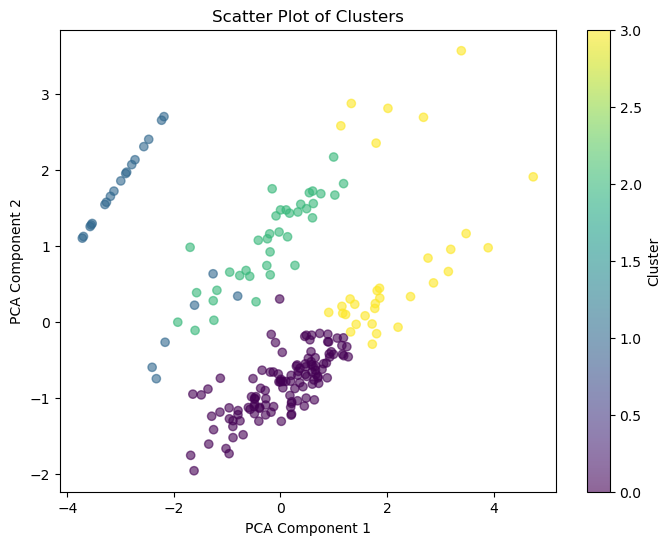

Scatter plot saved to output/scatter_plot_clusters.png


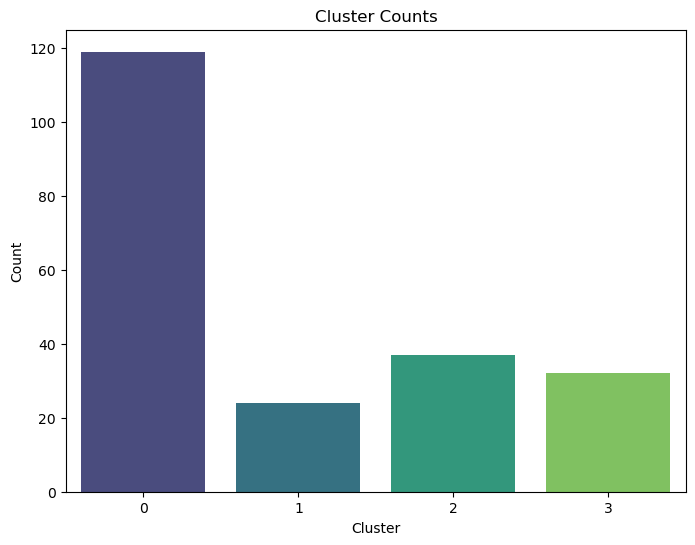

Cluster counts plot saved to output/cluster_counts.png


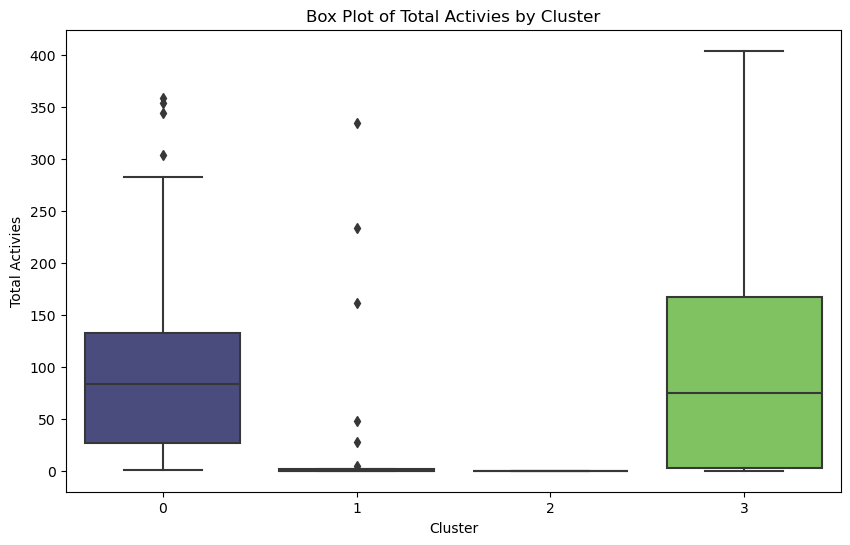

Box plot saved to output/boxplot_total_activities_by_cluster.png
Process completed successfully.


In [1]:
import os
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def load_data(file_path, sheet_name):
    """
    Load data from an Excel file and strip column names.
    """
    df = pd.read_excel(file_path, sheet_name=sheet_name)
    df.columns = df.columns.str.strip()  # Remove extra spaces
    return df

def ensure_column_exists(df, column_name, alternative_names=None):
    """
    Ensure that a column exists in the DataFrame, optionally checking alternative names.
    """
    if column_name in df.columns:
        return column_name
    elif alternative_names:
        for alt_name in alternative_names:
            if alt_name in df.columns:
                return alt_name
    raise ValueError(f"Column '{column_name}' or alternatives {alternative_names} not found.")

def create_financial_features(df):
    """
    Create financial and time-based features to enhance clustering.
    """
    # Current Year
    current_year = datetime.now().year

    # Debt-to-Income Ratio
    df['Debt_to_Income_Ratio'] = df['Outstanding Principal'] / df['Qualified / Verified\nIncome']
    
    # Remaining Loan Percentage
    df['Remaining_Loan_Percentage'] = df['Outstanding Balance'] / df['Loan Amount']
    
    # Loan-to-Income Ratio
    df['Loan_to_Income_Ratio'] = df['Loan Amount'] / df['Qualified / Verified\nIncome']
    
    # Monthly Repayment Burden
    df['Monthly_Repayment_Burden'] = df['Outstanding Balance'] / df['Loan Term (Months)']
    
    # Consistency Score
    df['Consistency_Score'] = df['Average activities per day'] / df['Average total activities per month']
    
    # Customer Age
    df['Date of Birth'] = pd.to_datetime(df['Date of Birth'], errors='coerce')
    df['Age'] = current_year - df['Date of Birth'].dt.year

    # Loan Tenure Remaining
    df['Disbursement Date'] = pd.to_datetime(df['Disbursement Date'], errors='coerce')
    df['Elapsed_Months'] = (datetime.now() - df['Disbursement Date']).dt.days // 30
    df['Remaining_Tenure'] = df['Loan Term (Months)'] - df['Elapsed_Months']
    
    # Handle infinite or NaN values (e.g., divide-by-zero cases)
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.fillna(0, inplace=True)
    
    print("Financial and time-based features created successfully.")
    return df

def preprocess_data(df, total_activities_col, columns_to_remove):
    """
    Preprocess the data by dropping unnecessary columns, handling missing values,
    encoding categorical variables, and scaling features.
    """
    # Save the ID column separately for reference
    df['ID'] = df['ID'].astype(str)
    
    # Preserve original dataset for reference
    df_original = df.copy()
    
    # Remove unnecessary columns
    existing_columns_to_remove = [col for col in columns_to_remove if col in df.columns]
    df = df.drop(columns=existing_columns_to_remove)
    
    # Drop columns with more than 50% missing data
    threshold = len(df) * 0.5
    df = df.dropna(thresh=threshold, axis=1)
    
    # Handle missing values
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    categorical_cols = df.select_dtypes(include=['object']).columns
    
    imputer_num = SimpleImputer(strategy='mean')
    imputer_cat = SimpleImputer(strategy='most_frequent')
    
    if not numeric_cols.empty:
        df[numeric_cols] = pd.DataFrame(
            imputer_num.fit_transform(df[numeric_cols]),
            columns=numeric_cols,
            index=df.index
        )
    
    if not categorical_cols.empty:
        df[categorical_cols] = pd.DataFrame(
            imputer_cat.fit_transform(df[categorical_cols]),
            columns=categorical_cols,
            index=df.index
        )
    
    # One-Hot Encoding specifically for Loan Status
    if 'Loan Status' in df.columns:
        df = pd.get_dummies(df, columns=['Loan Status'], drop_first=False)  # Keep all binary columns for loan statuses

    # Binary Encoding for Gender
    if 'Gender' in df.columns:
        df['Gender'] = df['Gender'].map({'MALE': 0, 'FEMALE': 1})

    # One-Hot Encoding for other categorical columns
    categorical_columns_to_encode = ['Province', 'Residential Status']
    columns_to_encode = [col for col in categorical_columns_to_encode if col in df.columns]
    df = pd.get_dummies(df, columns=columns_to_encode, drop_first=True)

    # Scale the features
    scaler = StandardScaler()
    df[df.select_dtypes(include=['float64', 'int64']).columns] = scaler.fit_transform(df.select_dtypes(include=['float64', 'int64']))
    
    print("Processed data (head):")
    print(df.head())
    return df, df_original

def perform_pca(df_encoded, variance_threshold=0.9):
    """
    Perform PCA on the encoded data to reduce dimensionality while retaining specified variance.
    """
    pca = PCA(n_components=variance_threshold, random_state=42)
    df_pca = pd.DataFrame(pca.fit_transform(df_encoded))
    print(f"Number of PCA components selected to retain {variance_threshold*100}% variance: {df_pca.shape[1]}")
    print("Explained variance by PCA components:")
    print(pca.explained_variance_ratio_)
    return df_pca

def determine_optimal_clusters(df_pca, k_range=range(2, 8)):
    """
    Determine the optimal number of clusters using the silhouette score.
    """
    silhouette_scores = []
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=20)
        labels = kmeans.fit_predict(df_pca)
        silhouette_avg = silhouette_score(df_pca, labels)
        silhouette_scores.append(silhouette_avg)
        print(f"Silhouette Score for k={k}: {silhouette_avg:.4f}")
    
    optimal_k = k_range[silhouette_scores.index(max(silhouette_scores))]
    print(f"Optimal number of clusters: {optimal_k}")
    print(f"Highest Silhouette Score: {max(silhouette_scores):.4f}")
    return optimal_k

def perform_clustering(df_pca, df_original, optimal_k):
    """
    Perform KMeans clustering with the optimal number of clusters and assign cluster labels.
    """
    kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=20)
    df_original['Cluster'] = kmeans.fit_predict(df_pca)
    return df_original

def save_clustered_data(df_original, output_dir="output", filename="final_output_with_clusters.csv"):
    """
    Save the clustered dataset to a CSV file.
    """
    os.makedirs(output_dir, exist_ok=True)
    output_path = os.path.join(output_dir, filename)
    df_original.to_csv(output_path, index=False)
    print(f"Clustered data saved to {output_path}")

def plot_clusters(df_pca, df_original, total_activities_col, output_dir="output"):
    """
    Create and save cluster visualization plots.
    """
    os.makedirs(output_dir, exist_ok=True)
    
    # Scatter Plot of Clusters
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(df_pca.iloc[:, 0], df_pca.iloc[:, 1], c=df_original['Cluster'], cmap='viridis', alpha=0.6)
    plt.title('Scatter Plot of Clusters')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.colorbar(scatter, label='Cluster')
    scatter_plot_path = os.path.join(output_dir, "scatter_plot_clusters.png")
    plt.savefig(scatter_plot_path)
    plt.show()
    print(f"Scatter plot saved to {scatter_plot_path}")
    
    # Cluster Counts
    plt.figure(figsize=(8, 6))
    cluster_counts = df_original['Cluster'].value_counts().sort_index()
    sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette='viridis')
    plt.title('Cluster Counts')
    plt.xlabel('Cluster')
    plt.ylabel('Count')
    cluster_counts_path = os.path.join(output_dir, "cluster_counts.png")
    plt.savefig(cluster_counts_path)
    plt.show()
    print(f"Cluster counts plot saved to {cluster_counts_path}")
    
    # Box Plot of Total Activities by Cluster
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df_original, x='Cluster', y=total_activities_col, palette='viridis')
    plt.title(f'Box Plot of {total_activities_col} by Cluster')
    plt.xlabel('Cluster')
    plt.ylabel(total_activities_col)
    boxplot_path = os.path.join(output_dir, "boxplot_total_activities_by_cluster.png")
    plt.savefig(boxplot_path)
    plt.show()
    print(f"Box plot saved to {boxplot_path}")

def main():
    # File and sheet details
    file_path = 'Data 3 - October, 2024.xlsx'
    sheet_name = 'Parachute - Cross Section'
    
    # Load the data
    df = load_data(file_path, sheet_name)

    # Ensure "Total Activities" column exists
    total_activities_col = ensure_column_exists(df, 'Total Activities', alternative_names=['Total Activies'])
    
    # Create financial and time-based features
    df = create_financial_features(df)
    
    # Columns to remove
    columns_to_remove = [
        # Original columns
        'Disbursement Date', 'Loan Amount', 'Outstanding Balance', 'Outstanding Principal', 'Interest Rate',
        'Loan Term (Months)', 'Date of Birth', 'Gender', 'Province', 'Stated Income on application',
        'Qualified / Verified\nIncome', "Aptitude for change Score", "Financial Literacy Score", 
        "Self Assessments", "Quiz Count", "Mood Count", "Inspiration Count","Total Activies", "Average total activities per month", 
        "Average activities per day",  "ID",
        # Created columns to remove
        'Age', 'Remaining_Tenure', 'Elapsed_Months', 'Residential Status','Monthly_Repayment_Burden'
    ]
    
    # Ensure only columns in the dataset are removed
    columns_to_remove = [col for col in columns_to_remove if col in df.columns]
    
    # Preprocess the data
    print("Preprocessing the data...")
    df_encoded, df_original = preprocess_data(df, total_activities_col, columns_to_remove)
    
    # Check the data after preprocessing
    print("Data after preprocessing:")
    print(df_encoded.head())
    
    # Perform PCA
    print("Performing PCA...")
    df_pca = perform_pca(df_encoded, variance_threshold=0.9)
    
    # Determine optimal number of clusters
    print("Determining the optimal number of clusters...")
    optimal_k = determine_optimal_clusters(df_pca, k_range=range(2, 8))
    
    # Perform clustering
    print(f"Performing KMeans clustering with k={optimal_k}...")
    df_clustered = perform_clustering(df_pca, df_original, 4)
    # df_clustered = perform_clustering(df_pca, df_original, optimal_k)
    
    # Save the clustered dataset
    print("Saving the clustered dataset...")
    save_clustered_data(df_clustered)
    
    # Visualizations
    print("Generating cluster visualizations...")
    plot_clusters(df_pca, df_clustered, total_activities_col)
    print("Process completed successfully.")

if __name__ == "__main__":
    main()

In [3]:
df_clustered = perform_clustering(df_pca, df_original, optimal_k)

NameError: name 'perform_clustering' is not defined

In [2]:
cluster_summary = df_clustered.groupby("Cluster").mean()
print(cluster_summary)

NameError: name 'df_clustered' is not defined